## Introduction
#### This notebook will be where I figure out how to adapt the PyTorch Dataset, DataModule, and PyTorch-Lightning LightningModule classes to the needs of this project. I will largely be following the framework laid out by Drew in the demonstration at https://colab.research.google.com/drive/1jJw5ftWR2So9sEkl2wGtIW3Z-ovNOFvp#scrollTo=mZkpyaIMPj6L, but there will necessarily be some large departures from this approach.

In [1]:
# Standard imports
import numpy as np
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, fixed
import sys
import yaml
from pathlib import Path
import shutil
import json
from typing import List, Union
import gc
import zipfile
from pathlib import Path
import re
import pickle

# Deep learning imports.
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset

import torchvision
from torchvision.utils import draw_bounding_boxes, make_grid
from torchvision.ops import masks_to_boxes, box_area
import torchvision.transforms.functional as TF
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

import torchmetrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision, compute_area

# Additional settings.
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

sys.path.append(sys.path[0]+'/..')
from he6_cres_deep_learning.daq import DAQ, Config
root_dir = sys.path[0]+'/config/fasterRCNN'

## Define Dataset class that will load spec files and targets

In [2]:
class CRES_Dataset(torch.utils.data.Dataset):
    """
    Following the structure necessitated by PyTorch, defining the Dataset class for this
    data. This involves the required __init__ and __getitem__ functions, but also
    will be responsible for formatting the data into the torch.tensor structures required
    for the RCNN model. 
    """

    def __init__(
        self, root_dir, freq_bins=4096, max_pool=3, file_max=10, transform=None
    ):
        """
        Args:
            root_dir (string): Directory with all the spec files and targets.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.root_dir = root_dir
        self.freq_bins = freq_bins
        self.max_pool = max_pool
        self.file_max = file_max
        self.transform = transform

        self.imgs, self.targets = self.collect_imgs_and_targets()

        # Guarentee the correct type.
        self.imgs = self.imgs.type(torch.ByteTensor)

        return None

    def __getitem__(self, idx):

        img = self.imgs[idx]
        target = self.targets[idx]

        if self.transform:
            img = self.transform(img)

        return img, target

    def __len__(self):

        return len(self.imgs)

    def collect_imgs_and_targets(self):

        img_dir = self.root_dir + "/spec_files"
        target_dir = self.root_dir + "/label_files"

#--------------------------------------------------------------------------------------------------- 
        # TODO: make it so directories get spec_prefix instead of files
        imgs, exp_name = self.load_spec_dir(img_dir)
#---------------------------------------------------------------------------------------------------        
        # Is this really the best way to scale the bboxes?
        targets = self.load_target_dir(target_dir, exp_name)
        # targets = targets.long()

        return imgs, targets

    def load_spec_dir(self, dir_path):
        """
        Loads all of the images in a directory into torch images.

        Args:
            dir_path (str): path should point to a directory that only contains
                .JPG images. Or any image type compatible with cv2.imread().

        Returns:
            imgs (List[torch.ByteTensor[1, H, W]]): list of images (each a
                torch.ByteTensor of shape(1, H, W)). Also returns the experiment
                name in this case, as each simulation is not yet being aggregated
                to ensure accurate matching of file numbers/events. 
        """
        path_glob = Path(dir_path).glob("**/*")
        files = [x for x in path_glob if x.is_file()]
        file_names = [str(x.name) for x in files]
        files = [str(x) for x in files]
        
        # extract experiment name to match to target file 
        exp_name = list(set(re.findall(r'[a-zA-Z0-9]+', name)[0] for name in file_names))
        
        # Extract the file index from the file name.
        file_idxs = [int(re.findall(r"\d+", name)[0]) for name in file_names]

        # Sort the files list based on the file_idx.
        files = [
            file
            for (file, file_idx) in sorted(
                zip(files, file_idxs), key=lambda pair: pair[1]
            )
        ]
        
        # Maxpool to use on images
        maxpool = nn.MaxPool2d(self.max_pool, self.max_pool, return_indices=False)

        if len(files) == 0:
            raise UserWarning("No files found at the input path.")

        imgs = []
        for file in files[: self.file_max]:
            img = self.spec_to_numpy(file)
            img = torch.from_numpy(img).unsqueeze(0)
            img = img.permute(0, 2, 1)

            # Apply max pooling now so we never have to hold the large images.

            imgs.append(maxpool(img.float()))

        imgs = torch.stack(imgs)

        return imgs, exp_name
    
    def load_target_dir(self, dir_path, exp_name): 
        """
        Load bbox json files. Apply max pooling reduction and ensure
        boxes still make physical sense. 
        Returns list of dictionaries with keys 'boxes' and 'labels', 
        boxes are in [x1, y1, x2, y2] format, and labels will all be 1
        since this simulation is only looking for events. 
        """
        path_glob = Path(dir_path).glob(f"{exp_name}*")
        files = [x for x in path_glob if x.is_file()]
        files = [str(x) for x in files]

        if len(files) == 0:
            raise UserWarning("No files found at the input path.")
        
        # targets will be a list of dicts that contain the bboxes, labels, and scores
        targets = []
        targets_dict = {'boxes': [],
                        'labels': []}
        for file in files[: self.file_max]:
            # read all bboxes for experiment
            with open(file, 'r') as f:
                bboxes = json.load(f)
                
                # each value corresponds to a file number
                for file_num, bbox_dict in bboxes.items():
                    # make sure we've populated the dict at least once before appending to list
                    if file_num != '0':
                        targets.append(targets_dict)
                        targets_dict = {'boxes': [],
                                        'labels': []}
                        
                    # each bbox corresponds to an event in the file
                    for bbox in bbox_dict.values():
                        # apply maxpooling reduction before appending
                        bbox = torch.tensor(bbox)/self.max_pool
                        bbox = bbox.round().int()
                        # max pooling can lead to tracks with no pixel width, avoid this
                        if bbox[3] == bbox[1]:
                            bbox[3] += 1
                        if bbox[2] == bbox[0]:
                            bbox[2] += 1
                        targets_dict['boxes'].append(bbox)
                        targets_dict['labels'].append(torch.tensor([1]))
                        
        targets.append(targets_dict)
        targets_dict = {'boxes': [],
                        'labels': []}
        for target in targets:
            target['boxes'] = torch.stack(target['boxes'])
            target['labels'] = torch.tensor(target['labels'])
        return targets
        

    def spec_to_numpy(
        self, spec_path, slices=-1, packets_per_slice=1, start_packet=None
    ):
        """
        TODO: Document.
        Making this just work for one packet per spectrum because that works for simulation in Katydid.
        * Make another function that works with 4 packets per spectrum (for reading the Kr data).
        """

        BYTES_IN_PAYLOAD = self.freq_bins
        BYTES_IN_HEADER = 32
        BYTES_IN_PACKET = BYTES_IN_PAYLOAD + BYTES_IN_HEADER

        if slices == -1:
            spec_array = np.fromfile(spec_path, dtype="uint8", count=-1).reshape(
                (-1, BYTES_IN_PACKET)
            )[:, BYTES_IN_HEADER:]
        else:
            spec_array = np.fromfile(
                spec_path, dtype="uint8", count=BYTES_IN_PAYLOAD * slices
            ).reshape((-1, BYTES_IN_PACKET))[:, BYTES_IN_HEADER:]
        
        if packets_per_slice > 1:

            spec_flat_list = [
                spec_array[(start_packet + i) % packets_per_slice :: packets_per_slice]
                for i in range(packets_per_slice)
            ]
            spec_flat = np.concatenate(spec_flat_list, axis=1)
            spec_array = spec_flat

        return spec_array

#### Sanity check the Dataset

In [5]:
cres_ds = CRES_Dataset(root_dir, max_pool=1, file_max=5)
cres_ds.imgs.shape, cres_ds.targets[0]

(torch.Size([5, 1, 4096, 5126]),
 {'boxes': tensor([[3287, 2309, 5126, 2344],
          [ 937, 4000, 4002, 4032],
          [4765, 3028, 5126, 3029],
          [2361, 2567, 5126, 2677],
          [2756, 1894, 5126, 1999]], dtype=torch.int32),
  'labels': tensor([1, 1, 1, 1, 1])})

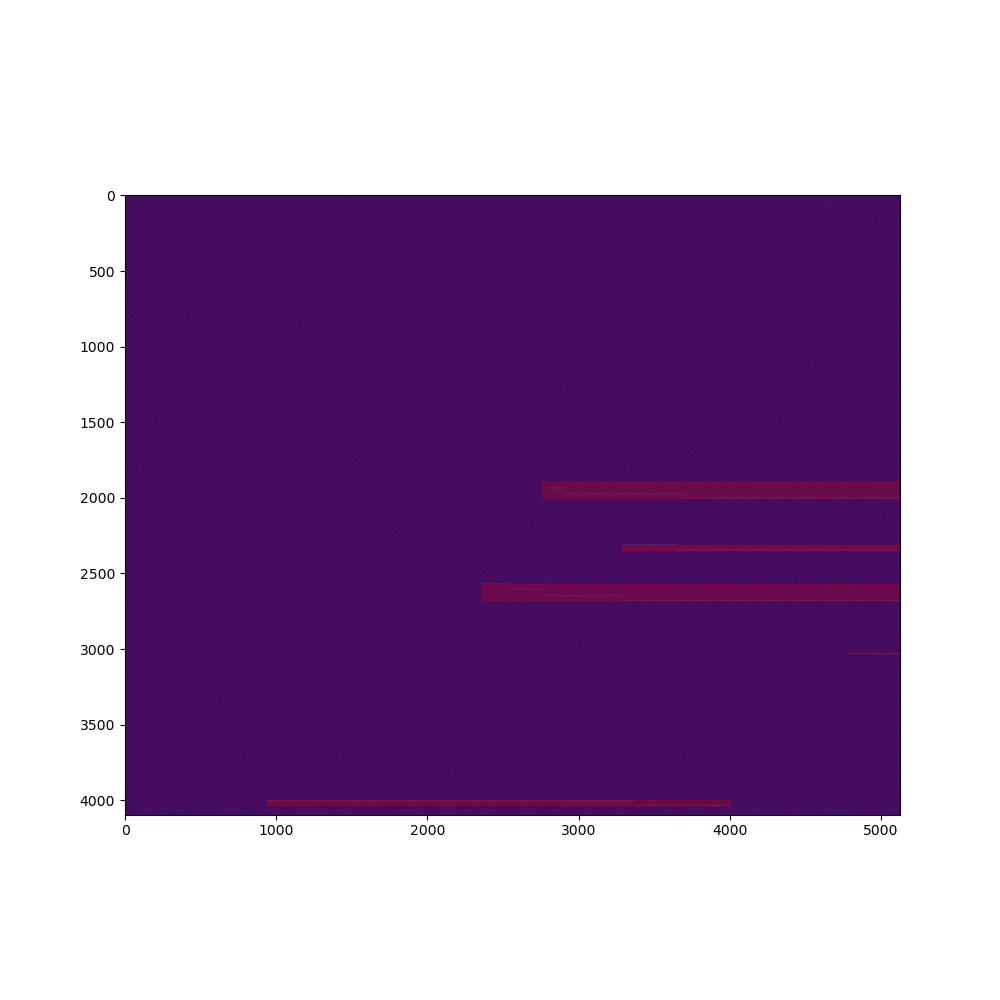

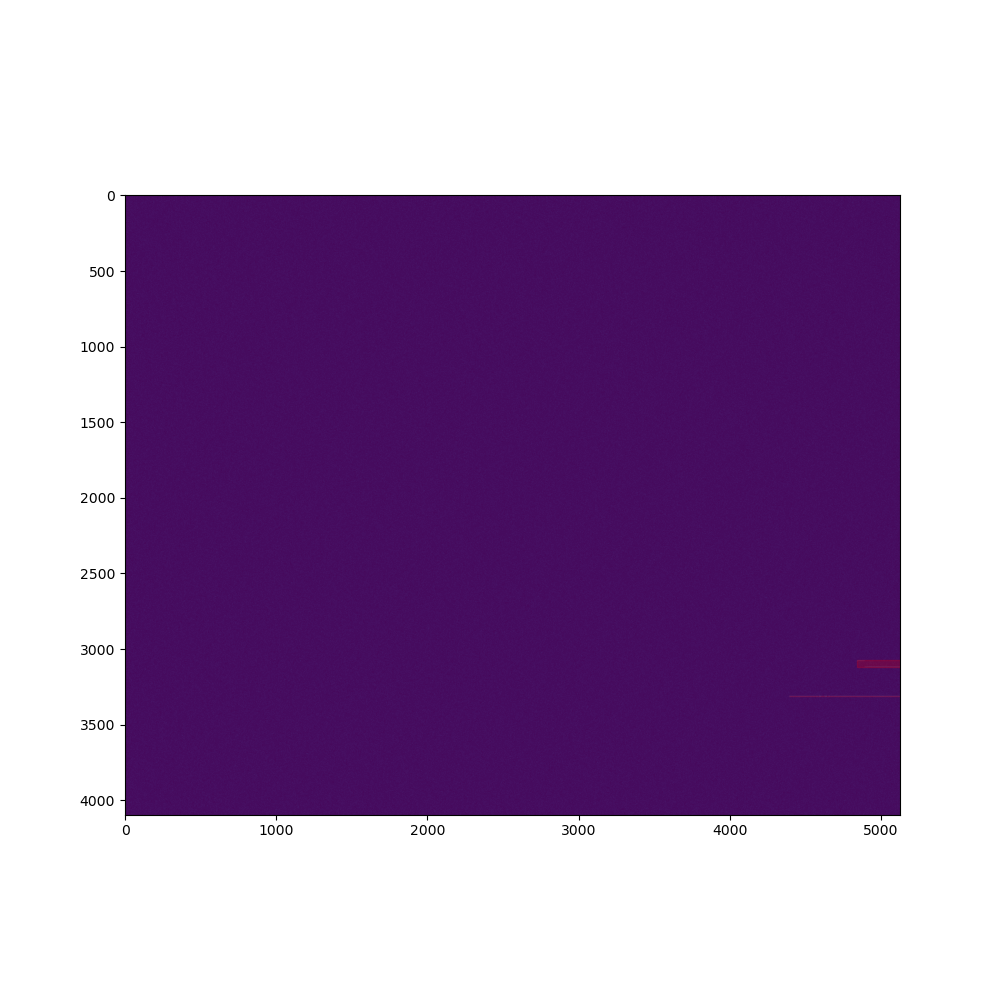

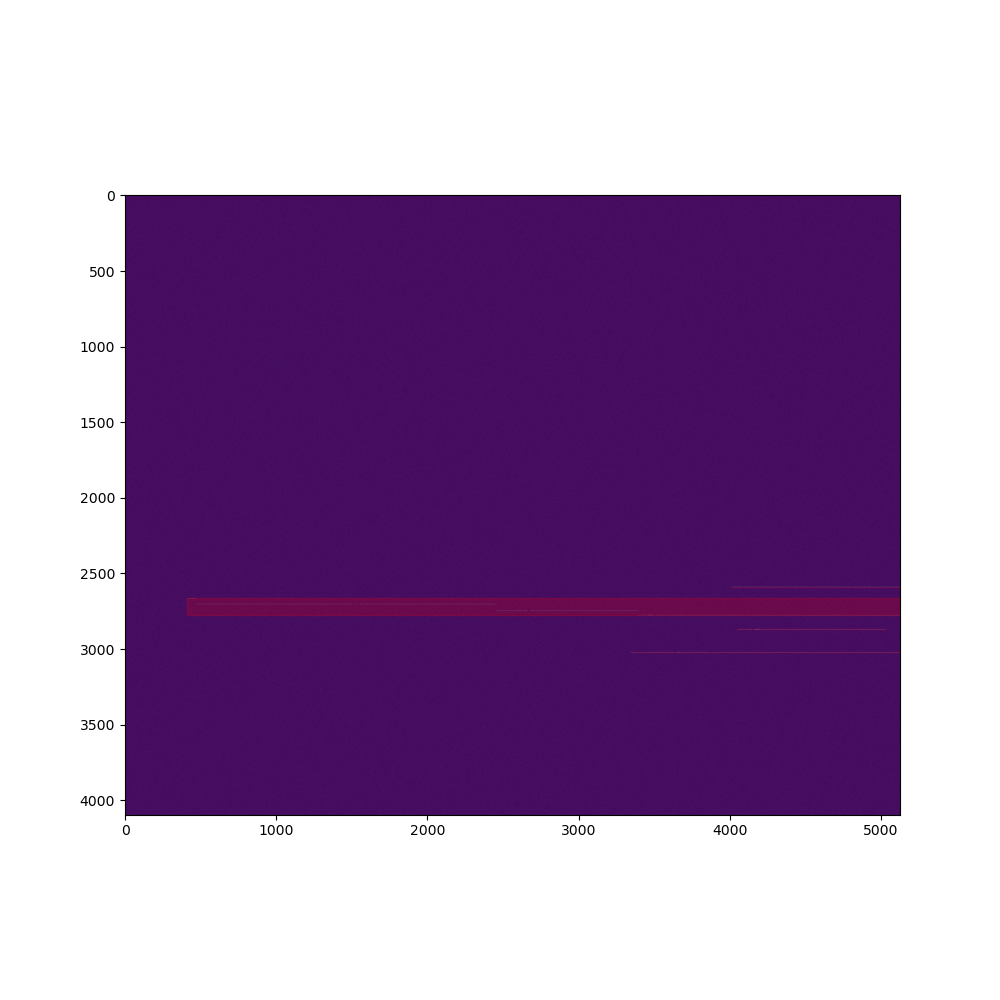

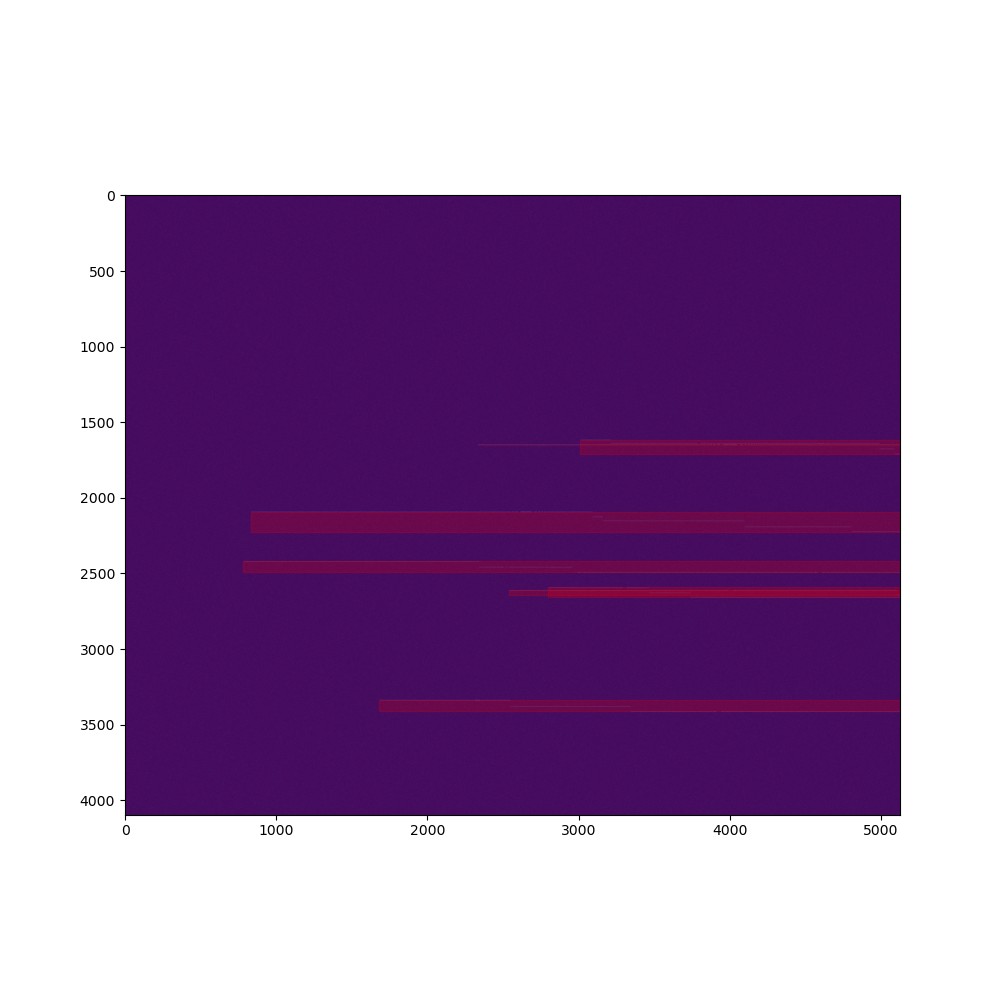

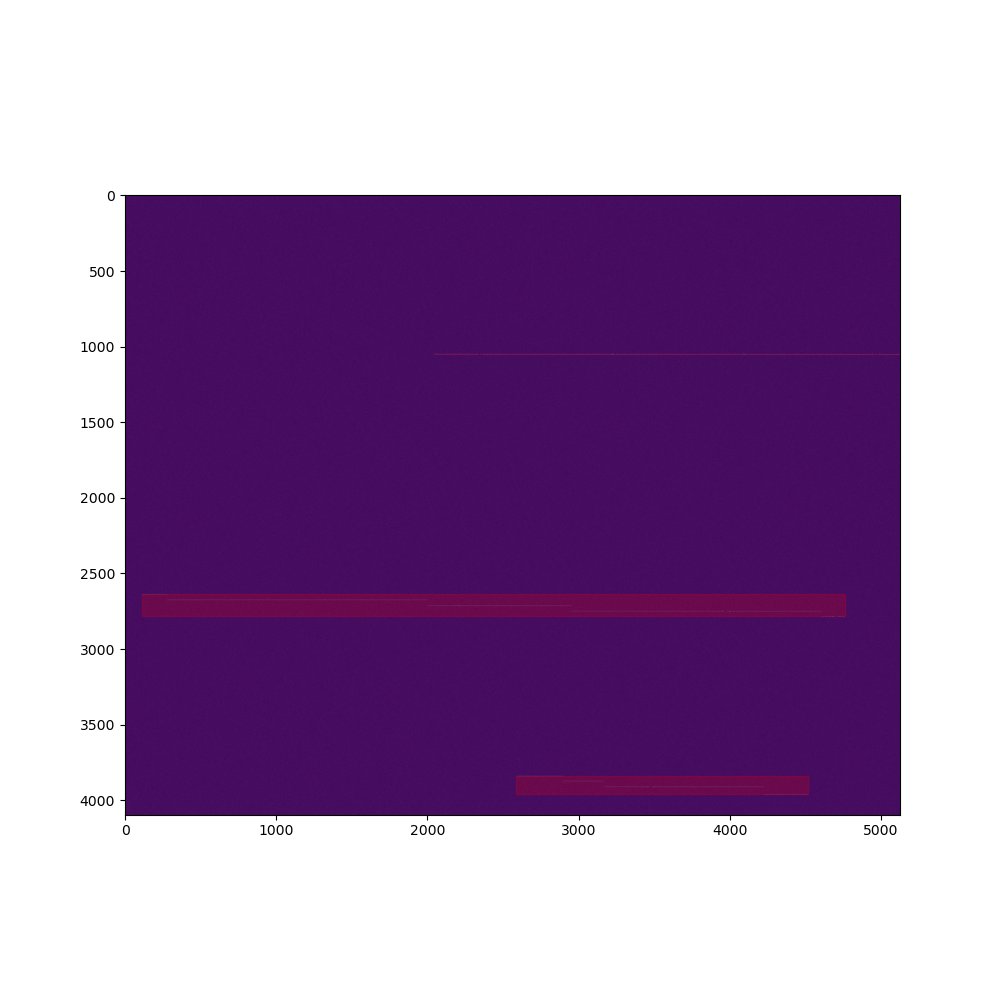

In [6]:
%matplotlib widget
for image, target_dict in zip(cres_ds.imgs, cres_ds.targets):
    fig, ax = plt.subplots(figsize=(10,10))
    plt.imshow(image[0])
    for target in target_dict['boxes']:
        width = target[2]-target[0]
        height = target[3]-target[1]
        ax.add_patch(Rectangle(target, width, height, alpha=.2, color='red'))
    plt.show()

#### Looking good. Let's explore how this changes as a function of `max_pool`

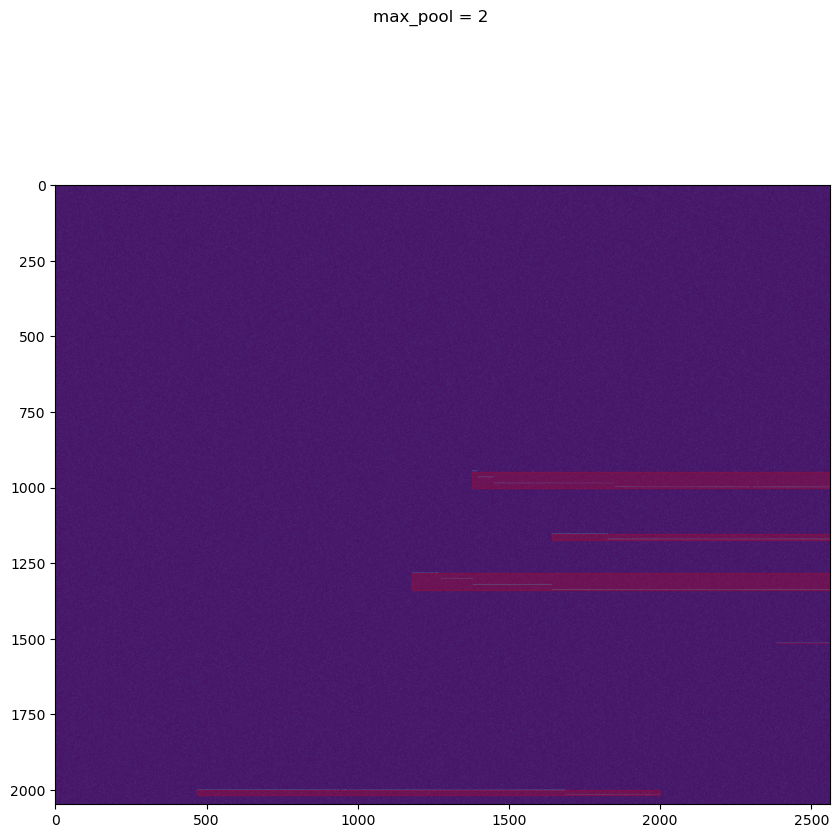

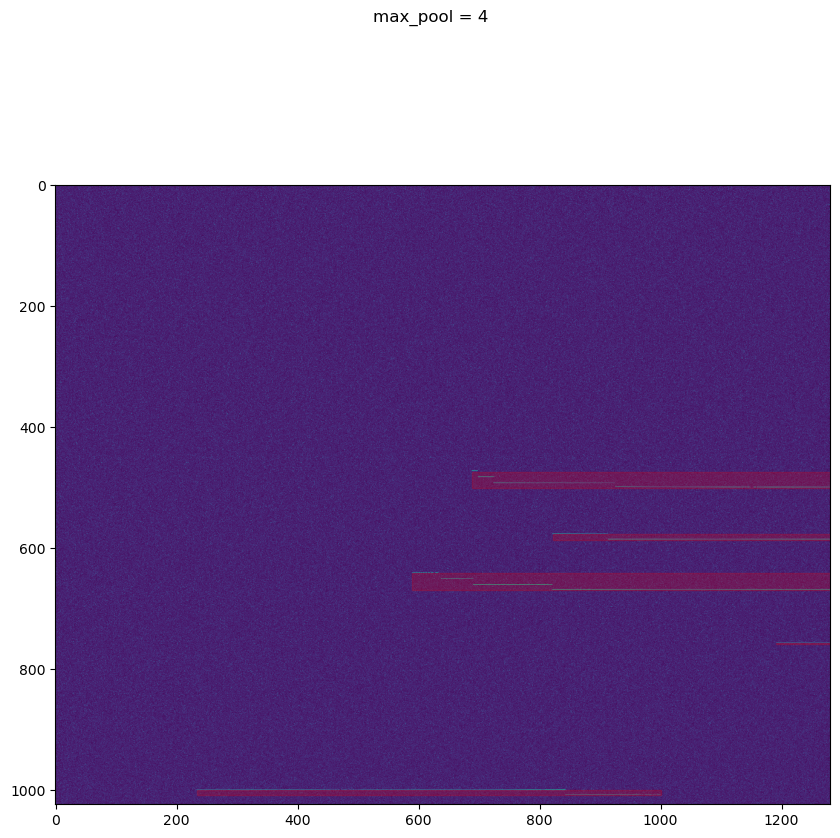

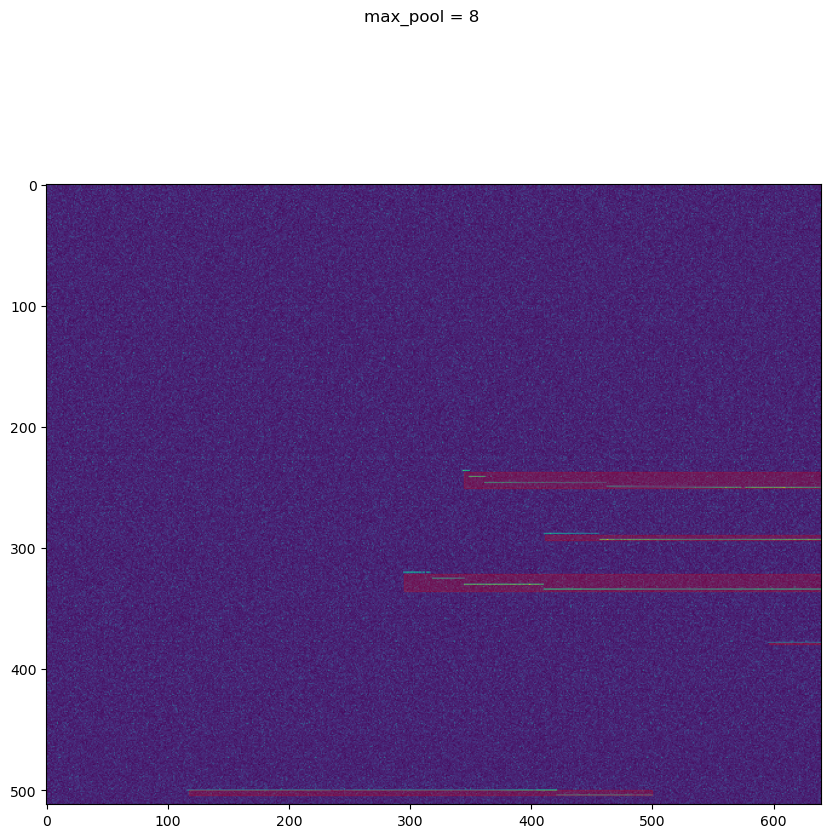

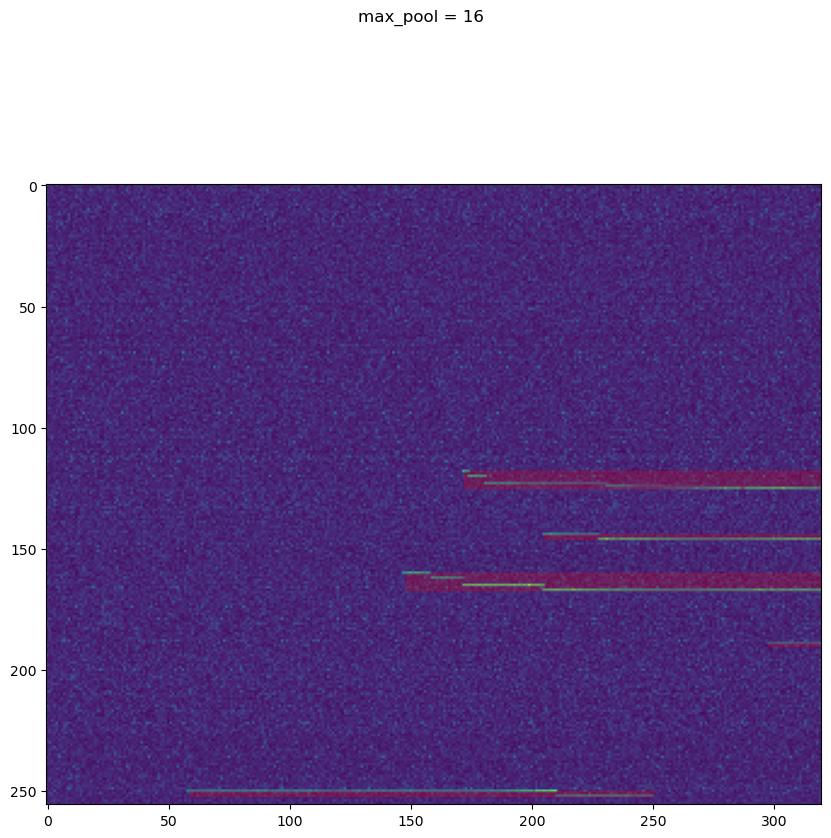

In [10]:
cres_list = [CRES_Dataset(root_dir, max_pool=2**i, file_max=1) for i in range(1, 5)]
for ds in cres_list:
    for image, target_dict in zip(ds.imgs, ds.targets):
        fig, ax = plt.subplots(figsize=(10,10))
        plt.imshow(image[0])
        for target in target_dict['boxes']:
            width = target[2]-target[0]
            height = target[3]-target[1]
            ax.add_patch(Rectangle(target, width, height, alpha=.2, color='red'))
        plt.suptitle(f'max_pool = {ds.max_pool}')
        plt.show()

#### **Important Note**: the boundary box limits suffer from rounding error when maxpooling is applied. Need to devise a scheme to ensure that the corners of the box remains on the target. It is never more than one pixel off in x,y, but still needs to be addressed at some point. 

## Define LightningDataModule that will handle train/val/test splitting of data for modeling

In [8]:
class CRES_DM(pl.LightningDataModule):
    """
    The LightningDataModule handles the train/test splitting, and defines
    the DataLoaders for each of these cases. For use with the LightningModule,
    helps reduce the amount of boilerplate code that needs to be written. The
    class structure is defined here as a binary classification problem - either
    the bounding box surrounds an event or not. The custom collate function 
    ended up being the most finnicky part of the process. 
    """

    def __init__(
        self,
        root_dir,
        freq_bins=4096,
        max_pool=8,
        file_max=10,
        transform=None,
        train_val_test_splits=(0.6, 0.3, 0.1),
        batch_size=1,
        shuffle_dataset=True,
        seed=42,
        num_workers=0,
        class_map={
            0: {
                "name": "background",
                "target_color": (255, 255, 255),
            },
            1: {"name": "event", "target_color": (255, 0, 0)}
        },
    ):

        super().__init__()

        # Attributes.
        self.root_dir = root_dir
        self.freq_bins = freq_bins
        self.max_pool = max_pool
        self.file_max = file_max
        self.transform = transform
        self.class_map = class_map
        self.train_val_test_splits = train_val_test_splits
        self.batch_size = batch_size
        self.shuffle_dataset = shuffle_dataset
        self.seed = seed
        self.num_workers = num_workers
        self.setup()

    def setup(self, stage=None):

        self.cres_dataset = CRES_Dataset(
            self.root_dir,
            freq_bins=self.freq_bins,
            max_pool=self.max_pool,
            file_max=self.file_max,
            transform=self.transform,
        )

        # Creating data indices for training and validation splits:
        dataset_size = len(self.cres_dataset)
        indices = list(range(dataset_size))
        splits = self.train_val_test_splits
        split_idxs = [
            int(np.floor(splits[0] * dataset_size)),
            int(np.floor((splits[0] + splits[1]) * dataset_size)),
        ]

        if self.shuffle_dataset:
            rng = np.random.default_rng(self.seed)
            rng.shuffle(indices)

        train_indices, val_indices, test_indices = (
            indices[: split_idxs[0]],
            indices[split_idxs[0] : split_idxs[1]],
            indices[split_idxs[1] :],
        )

        # Creating PT data samplers and loaders. For now only train is shuffled.
        self.train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        self.val_sampler = torch.utils.data.SequentialSampler(val_indices)
        self.test_sampler = torch.utils.data.SequentialSampler(test_indices)

        return None

    def collate_fn(self, batch):
        """
        When dealing with lists of target dictionaries one needs to be 
        careful how the batches are collated. The default pytorch dataloader 
        behaviour is to return a single dictionary for the whole batch of 
        images which won't work as input to the mask rcnn model. Instead 
        we want a list of dictionaries; one for each image. See here for 
        more details on the dataloader collate_fn:
        https://python.plainenglish.io/understanding-collate-fn-in-pytorch-f9d1742647d3

        Returns:
            imgs (torch.UInt8Tensor[batch_size, 1, img_size, img_size]): 
                batch of images.
            targets (List[Dict[torch.Tensor]]): list of dictionaries of 
                length batch_size.

        """
        imgs = []
        targets = []

        for img, target in batch:
            imgs.append(img)
            targets.append(target)

        # Converts list of tensor images (of shape (1,H,W) and len batch_size)
        # into a tensor of shape (batch_size, 1, H, W).
        imgs = torch.stack(imgs)

        return imgs, targets
    
    def train_dataloader(self):
        return DataLoader(
            self.cres_dataset,
            batch_size=self.batch_size,
            sampler=self.train_sampler,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn
        )

    def val_dataloader(self):
        return DataLoader(
            self.cres_dataset,
            batch_size=self.batch_size,
            sampler=self.val_sampler,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn
        )

    def test_dataloader(self):
        return DataLoader(
            self.cres_dataset,
            batch_size=self.batch_size,
            sampler=self.test_sampler,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn
        )

In [9]:
cres_dm = CRES_DM(root_dir, max_pool=32)

### Can test the DataModule by doing the 'overfit' procedure, meaning fit a model on a small batch of data. First, define function to load the model to be trained <br> **Important Note:** if not running on a GPU instance this will take a LONG time. The results of this procedure are saved as `overfit_preds.pkl` and are examined below.

In [12]:
def get_fasterrcnn(num_classes=2, pretrained=True):
    """A function for loading the PyTorch implementation of FasterRCNN.
    To not have predictor changed at all set num_classes = -1.
    See here for documentation on the input and output specifics:
    https://pytorch.org/vision/stable/models/faster_rcnn.html

    Args:
        num_classes (int): number of output classes desired.
        pretrained (bool): whether or not to load a model pretrained on the COCO dataset. 
    """

    # load Faster RCNN pre-trained model
    if pretrained:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    else:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)

    if num_classes != -1:
        # get the number of input features
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        # define a new head for the detector with required number of classes
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

#### Function for overfitting

In [13]:
def overfit(imgs, targets, model, optimizer,  device=None,  epochs= 100): 
    
    model = model.to(device)
    model.train()

    # Formatting for input to model. 
    imgs_normed = imgs / 255.0
    imgs_normed = imgs_normed.to(device)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    

    for epoch in range(epochs):

        loss_dict = model(imgs_normed, targets)

        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if epoch %25 == 0:
            print(f"epoch: {epoch}")
            print(f"loss {losses:.4f}\n")

    return None

In [30]:
print(f"Input shape:\n {cres_dm.cres_dataset.imgs[:4].shape} \nInput max: {cres_dm.cres_dataset.imgs[:4].max()}\n" )

print(f"Faster RCNN target for img 0:\n ")
for target in cres_dm.cres_dataset.targets[:4]:
    for key, val in target.items():
        print(f"{key}:\n {val}")

Input shape:
 torch.Size([4, 1, 64, 80]) 
Input max: 247

Faster RCNN target for img 0:
 
boxes:
 tensor([[51, 36, 80, 37],
        [15, 62, 63, 63],
        [74, 47, 80, 48],
        [37, 40, 80, 42],
        [43, 30, 80, 31]], dtype=torch.int32)
labels:
 tensor([1, 1, 1, 1, 1])
boxes:
 tensor([[69, 52, 80, 53],
        [76, 48, 80, 49]], dtype=torch.int32)
labels:
 tensor([1, 1])
boxes:
 tensor([[52, 47, 80, 48],
        [ 6, 42, 80, 43],
        [63, 40, 80, 41],
        [63, 45, 79, 46]], dtype=torch.int32)
labels:
 tensor([1, 1, 1, 1])
boxes:
 tensor([[12, 38, 80, 39],
        [26, 52, 80, 53],
        [47, 25, 80, 27],
        [40, 41, 80, 42],
        [13, 33, 80, 35],
        [44, 41, 80, 42],
        [36, 26, 80, 27]], dtype=torch.int32)
labels:
 tensor([1, 1, 1, 1, 1, 1, 1])


#### define model and optimizer, then run the overfit.

In [31]:
model = get_fasterrcnn(num_classes = 2, pretrained = True)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
device = "cuda" if torch.cuda.is_available() else "cpu"
# need to convert images to range (0,1)
overfit(cres_dm.cres_dataset.imgs[:4].float()/255., cres_dm.cres_dataset.targets[:4], model, optimizer, device, epochs=600)

epoch: 0
loss 8.8885

epoch: 25
loss 0.7215

epoch: 50
loss 0.7068

epoch: 75
loss 0.6568

epoch: 100
loss 0.6589

epoch: 125
loss 0.6120

epoch: 150
loss 0.6805

epoch: 175
loss 0.5998

epoch: 200
loss 0.7353

epoch: 225
loss 0.5137

epoch: 250
loss 0.2785

epoch: 275
loss 0.1363

epoch: 300
loss 0.1218

epoch: 325
loss 0.0927

epoch: 350
loss 0.0763

epoch: 375
loss 0.0527

epoch: 400
loss 0.0624

epoch: 425
loss 0.0481

epoch: 450
loss 0.0459

epoch: 475
loss 0.0391

epoch: 500
loss 0.0466

epoch: 525
loss 0.0332

epoch: 550
loss 0.0348

epoch: 575
loss 0.0438



#### Check that any predictions made (just looking for functionality, full fit to data will determine performance later)

In [32]:
def apply_score_cut(preds, score_threshold=0.5):
    """
    Takes a list of prediction dictionaries (one for each image) and cuts
    out all instances whose score is below the score threshold.

    Args:
        preds (List[Dict[torch.Tensor]]): predictions as output by the
            torchvision implimentation of MaskRCNN or FasterRCNN. The 
            scores are in the range (0,1) and signify the certainty of 
            the model for that instance.
            See link below for details on the target/prediction formatting.
            https://pytorch.org/vision/0.12/_modules/torchvision/models/detection/mask_rcnn.html
        score_threshold (float): the threshold to apply to the identified
            objects. If an instance is below the score_threshold it will
            be removed from the score_thresholded_preds dictionary.

    Returns:
        score_thresholded_preds (List[Dict[torch.Tensor]]): predictions
            that exceed score_threshold.
    """
    score_thresholded_preds = [
        {key: value[pred["scores"] > score_threshold] for key, value in pred.items()}
        for pred in preds
    ]

    return score_thresholded_preds

In [36]:
model.eval()
preds = model((cres_dm.cres_dataset.imgs[4:].float()/255.).cuda())
preds = apply_score_cut(preds, score_threshold=0.5)
preds

[{'boxes': tensor([[24.9175, 42.7023, 80.0000, 44.5647],
          [65.9944, 28.9764, 80.0000, 30.1219],
          [ 0.0000, 42.1277, 80.0000, 43.5934],
          [ 6.5970, 41.5604, 80.0000, 42.6694],
          [47.1140, 61.3589, 69.7227, 64.0000],
          [52.6857, 29.2192, 80.0000, 30.3976],
          [47.6146, 17.1094, 80.0000, 18.2467],
          [51.0259, 18.1265, 80.0000, 19.2948],
          [32.2470,  9.7748, 80.0000, 10.8831],
          [20.2113, 51.9096, 80.0000, 53.3210],
          [42.2772, 13.7965, 79.9067, 14.7107],
          [28.0242, 27.8987, 80.0000, 29.2916],
          [46.1607,  4.2003, 80.0000,  5.4590],
          [ 0.0000, 27.5211, 66.4682, 29.0643],
          [57.8712, 48.3110, 80.0000, 49.1103]], device='cuda:0',
         grad_fn=<IndexBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9777, 0.9742, 0.9739, 0.9535,
          0.9365, 0.8575, 0.8136, 0.8057,

#### Going to dump these to a pickle file so I can visualize the predictions locally

In [38]:
import pickle
with open('overfit_preds.pkl', 'wb') as file:
    pickle.dump(preds, file)

### Loading from pickle file to look at predictions from overfit

In [15]:
with open('overfit_preds.pkl', 'rb') as file:
    preds = torch.load(file, map_location=torch.device('cpu'))
    # preds = pickle.load(file)
preds

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

#### Define LightningModule class for training

In [31]:
class CRES_LM(pl.LightningModule):

    def __init__(self, num_classes = 2, lr = 3e-4, pretrained = False):
        super().__init__()

        # LM Attributes.
        self.num_classes = num_classes
        self.pretrained = pretrained
        self.lr = lr

        # Log hyperparameters. 
        self.save_hyperparameters()

        # Metrics.
        # self.iou = JaccardIndex(task='binary')
        # self.map_bbox = MeanAveragePrecision(iou_type = "bbox", class_metrics = False)

        # Faster RCNN model. 
        self.model = self.get_fasterrcnn_model(self.num_classes, self.pretrained)

    def forward(self, imgs):
        self.model.eval()
        imgs_normed = self.norm_imgs(imgs)
        return self.model(imgs_normed)

    def training_step(self, train_batch, batch_idx):

        imgs, targets = train_batch
        imgs_normed = self.norm_imgs(imgs)

        loss_dict = self.model(imgs_normed, targets)
        losses = sum(loss for loss in loss_dict.values())

        self.log('Loss/train_loss', losses)

        return losses

    def validation_step(self, val_batch, batch_idx):

        imgs, targets = val_batch
        preds = self.forward(imgs)
        
        iou_list = torch.tensor([box_iou(target["boxes"], pred["boxes"]).diag().mean() for target, pred in zip(targets, preds)])

        self.log('IoU_bbox/val',iou_list)
        self.log('Prediction_shape/val', float(len(preds[0]['boxes'])))
        self.log('targets_shape/val', float(len(targets[0]['boxes'])))
        return None

    def configure_optimizers(self): 

        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)

        return optimizer

    def get_fasterrcnn_model(self, num_classes, pretrained):
        
        # load Faster RCNN pre-trained model
        if pretrained: 
            model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
        else: 
            model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
        
        # get the number of input features 
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        # define a new head for the detector with required number of classes
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

        return model

    def norm_imgs(self, imgs): 

        imgs_normed = imgs.float() / 255.0

        return imgs_normed

In [32]:
# Define training object
cres_dm = CRES_DM(root_dir,
                  max_pool=16,
                  file_max=1000,
                  batch_size=1,
                  num_workers=4
                  )

In [33]:
cres_dm.cres_dataset.imgs.shape, len(cres_dm.cres_dataset.targets), cres_dm.cres_dataset.targets[0]

(torch.Size([1, 1, 256, 320]),
 1000,
 {'boxes': tensor([[205, 144, 320, 146],
          [ 59, 250, 250, 252],
          [298, 189, 320, 190],
          [148, 160, 320, 167],
          [172, 118, 320, 125]], dtype=torch.int32),
  'labels': tensor([1, 1, 1, 1, 1])})

In [34]:
# Create Instance of LightningModule
cres_lm = CRES_LM(num_classes = 2, lr = 1e-4, pretrained = True)

# Create callback for ModelCheckpoints. 
checkpoint_callback = ModelCheckpoint(filename='{epoch:02d}', 
                                      save_top_k = 15, 
                                      monitor = "Loss/train_loss", 
                                      every_n_epochs = 1)

# Define Logger. 
logger = TensorBoardLogger("tb_logs", name="cres", log_graph = False)

# Set device.
device = "gpu" if torch.cuda.is_available() else "cpu"

# Create an instance of a Trainer.
trainer = pl.Trainer(logger = logger, 
                     callbacks = [checkpoint_callback], 
                     accelerator = device, 
                     max_epochs = 10, 
                     log_every_n_steps = 1, 
                     check_val_every_n_epoch= 1)

# Fit. 
trainer.fit(cres_lm, cres_dm.train_dataloader(), cres_dm.val_dataloader())

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41.3 M
-------------------------------------
41.1 M    Trainable params
222 K     Non-trainable params
41.3 M    Total params
165.197   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/winston/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:111: UserWarning: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.
  rank_zero_warn(
/Users/winston/opt/anaconda3/lib/python3.8/site-packages/lightning_lite/utilities/data.py:55: UserWarning: `DataLoader` returned 0 length. Please make sure this was your intention.
  rank_zero_warn(
/Users/winston/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:111: UserWarning: Total length of `CombinedLoader` across ranks is zero. Please make sure this was your intention.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: No training batches.


In [35]:
%reload_ext tensorboard
%tensorboard --logdir tb_logs/

Reusing TensorBoard on port 6006 (pid 11364), started 0:38:42 ago. (Use '!kill 11364' to kill it.)

In [7]:
PATH = 'tb_logs/cres/version_{}/checkpoints/epoch={:02d}.ckpt'.format(54, 99)
cres_lm = CRES_LM.load_from_checkpoint(PATH)

In [25]:
cres_dm.setup(stage = "test")
test_dataiter = iter(cres_dm.test_dataloader())

In [36]:
imgs, targets = test_dataiter.next()
preds = cres_lm(imgs)

In [27]:
def apply_score_cut(preds, score_threshold=0.5):
    """
    Takes a list of prediction dictionaries (one for each image) and cuts
    out all instances whose score is below the score threshold.

    Args:
        preds (List[Dict[torch.Tensor]]): predictions as output by the
            torchvision implimentation of MaskRCNN or FasterRCNN. The 
            scores are in the range (0,1) and signify the certainty of 
            the model for that instance.
            See link below for details on the target/prediction formatting.
            https://pytorch.org/vision/0.12/_modules/torchvision/models/detection/mask_rcnn.html
        score_threshold (float): the threshold to apply to the identified
            objects. If an instance is below the score_threshold it will
            be removed from the score_thresholded_preds dictionary.

    Returns:
        score_thresholded_preds (List[Dict[torch.Tensor]]): predictions
            that exceed score_threshold.
    """
    score_thresholded_preds = [
        {key: value[pred["scores"] > score_threshold] for key, value in pred.items()}
        for pred in preds
    ]

    return score_thresholded_preds


def show(imgs, figsize=(10.0, 10.0)):

    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), figsize=figsize, squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = TF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

    return None

def display_boxes(imgs, target_pred_dict, class_map, width = 1, fill=False):

    num_imgs = len(imgs)
    result_imgs = [
        draw_bounding_boxes(
            imgs[i].type(torch.uint8),
            target_pred_dict[i]["boxes"].int(),
            fill=fill,
            colors=[
                class_map[j.item()]["target_color"]
                for j in target_pred_dict[i]["labels"]
            ],
            width=width,
        )
        for i in range(num_imgs)
    ]

    return result_imgs




In [37]:
%matplotlib inline
@interact
def vizualize_targets_predictions(
                                target_box = widgets.Checkbox(value=False,description='target boxes'),
                                pred_box = widgets.Checkbox(value=False,description='prediction boxes'),
                                num_imgs= widgets.IntSlider(value=len(preds),min=0,max=len(preds),step=1, description = "num_imgs"),
                                score_thresh = widgets.FloatSlider(value=.5,min=0,max=1,step=.0001, description = "score_thresh"),
                                width =  widgets.IntSlider(value=1,min=1,max=10,step=1), 
                                display_size = widgets.IntSlider(value=20,min=2,max=50,step=1)
                                ): 

    preds_cut = apply_score_cut(preds, score_threshold=score_thresh)
    result_image = [imgs[i] for i in range(num_imgs)]

    if target_box: 
        result_image = display_boxes(result_image, targets, cres_dm.class_map, fill = True)

    if pred_box: 
        result_image = display_boxes(result_image, preds_cut, cres_dm.class_map)

    grid = make_grid(result_image)
    show(grid, figsize = (display_size, display_size))

interactive(children=(Checkbox(value=False, description='target boxes'), Checkbox(value=False, description='pr…